CT2 TRAINING:
- 1JHN DONE (-1.55)
- 2JHN DONE (-2.65)
- 3JHN DONE (-2.96)
- 2JHH DONE (-2.66)
- 3JHH DONE (-2.93)
- 1JHC

CT2 NF TRAINING:
- 1JHN DONE (-1.55)
- 1JHC DONE (-1.38) (~100 epoch left)
- 2JHN DONE (-2.99)
- 2JHH DONE (-3.14) (45 epoch left) (forgot to save this model!!)
- 2JHC DONE (-2.60) (B2 & 120 epoch left)

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, pickle, numba, torch, tqdm, random, utils, os, gc, time
import networkx as nx
import gc, psutil
from collections import OrderedDict, defaultdict
from copy import deepcopy

from rdkit.Chem.AtomPairs.Utils import NumPiElectrons
from rdkit.Chem.rdMolTransforms import GetAngleRad, GetBondLength
from rdkit.Chem.rdchem import Atom, Bond
from rdkit.Chem.AtomPairs.Pairs import rdMolDescriptors as rdmd
from rdkit import Chem, RDConfig
from rdkit.Chem import ChemicalFeatures

import torch_geometric.transforms as T
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, Dropout, SELU
from torch_geometric.data import Data
from torch_geometric.nn import NNConv, Set2Set, GATConv
from torch_geometric.data import DataLoader


%config InlineBackend.figure_format ='retina'

In [2]:
psutil.virtual_memory()

svmem(total=31628324864, available=30632308736, percent=3.1, used=603918336, free=30322176000, active=574427136, inactive=486498304, buffers=62050304, cached=640180224, shared=11419648, slab=67538944)

In [3]:
train = pd.read_csv('train.csv')
structures = pd.read_csv("structures.csv")

In [4]:
gratio = pd.DataFrame({"atom":["H","C","N","O","F"],
                       "Gratio": [42.576,10.705,-4.316,-5.772,40.060],
                       "Eneg": [2.2,2.55,3.04,3.44,3.98],
                       "radius":[110,170,155,152,147],
                       "atomic_num":[1,6,7,8,9],
                       "numv":[1,4,5,6,7]})
structures = structures.merge(gratio,how='left',on='atom')

In [5]:
train = train.groupby('type').get_group('2JHC')

In [6]:
t2 = pd.read_csv('train.csv')
t2 = t2[t2['molecule_name'].isin(train['molecule_name'])]
t2.drop(['id','type','scalar_coupling_constant'],axis=1,inplace=True)

In [7]:
from collections import defaultdict
molcouples = defaultdict(list)
cpv = t2.values.tolist()
for c in tqdm.tqdm_notebook(cpv):
    molcouples[c[0]].append((c[1],c[2]))

In [8]:
train.drop('type',axis=1,inplace=True)

In [9]:
train = utils.map_atom_info(train,0,structures)
train = utils.map_atom_info(train,1,structures)

In [10]:
with open('rdkitmolecules.p', 'rb') as fp:
    d = pickle.load(fp)

In [11]:
tf = train.groupby('molecule_name')

In [12]:
groups = list(tf.groups.keys())

In [13]:
len(groups)

84810

In [14]:
with open("trainmols2JHC.txt", "rb") as fp:   # Unpickling
    trainmols = pickle.load(fp)    
with open("valmols2JHC.txt", "rb") as fp:   # Unpickling
    valmols = pickle.load(fp)    

In [15]:
len(trainmols)+len(valmols)

84810

In [16]:
len(trainmols)

76329

In [17]:
len(valmols)

8481

In [18]:
76329/2

38164.5

In [19]:
trainmols =  trainmols[38164:] #b2

In [20]:
#trainmols = trainmols[:38164]

In [21]:
tc = []
vc = [] 
for i in tqdm.tqdm_notebook(trainmols):
    g = tf.get_group(i)
    tc.append(g)
for i in tqdm.tqdm_notebook(valmols):
    g = tf.get_group(i)
    vc.append(g)

In [22]:
train = pd.concat(tc)

In [23]:
print(len(train),train['molecule_name'].nunique())

512721 38165


In [24]:
val = pd.concat(vc)

In [25]:
print(len(val),val['molecule_name'].nunique())

114100 8481


In [26]:
molnames = list(train['molecule_name'].unique())
mols = OrderedDict()

for name in molnames:
    mols[name] = d[name]
    
struct =  structures[structures['molecule_name'].isin(molnames)]
g = struct.groupby('molecule_name')

struct.head()

,molecule_name,atom_index,atom,x,y,z,Gratio,Eneg,radius,atomic_num,numv
27,dsgdb9nsd_000008,0,C,-0.008288,1.390470,-0.005601,10.705,2.55,170,6,4
28,dsgdb9nsd_000008,1,O,-0.007970,-0.025045,0.020306,-5.772,3.44,152,8,6
29,dsgdb9nsd_000008,2,H,1.006583,1.815564,0.003483,42.576,2.20,110,1,1
30,dsgdb9nsd_000008,3,H,-0.546575,1.799170,-0.873901,42.576,2.20,110,1,1
31,dsgdb9nsd_000008,4,H,-0.522889,1.725552,0.899073,42.576,2.20,110,1,1


In [27]:
struct['molecule_name'].nunique()

38165

In [28]:
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

In [29]:
atfn = {'Acceptor':0,
         'Aromatic':1,
         'Donor':2,
         'Hydrophobe':3,
         'LumpedHydrophobe':4,
         'NegIonizable':5,
         'PosIonizable':6,
         'ZnBinder':7}

In [30]:
#ADD DISTANCE TO TARGET FEATURE
def getAtomNodeFeats(molname, mols, data):
    symbol, x, y, z, gr,eneg,radius,atomnum,nv = 2,3,4,5,6,7,8,9,10
    mol = mols[molname]
    feats = factory.GetFeaturesForMol(mol)
    atfdict = defaultdict(list)
    for i in range(len(feats)):
        fam = feats[i].GetFamily()
        dl = feats[i].GetAtomIds()
        for aid in dl:
            atfdict[aid].append(fam)
    
    l = len(data)
    nodef = []
    
    eems = rdmd.CalcEEMcharges(mol)
    spfd = {'S':0,'SP':0.5,'SP2':1/3,'SP3':1/4}
    
    for i in range(l):
        d = data[i]
        atom = mol.GetAtomWithIdx(i)
        ahyb =  str(atom.GetHybridization())
        sym = d[symbol]
        hf = 'NONE'
        if i in atfdict:
            hf = atfdict[i]
        ff = [sym=='H',sym=='C',sym=='N',sym=='O',sym=='F',d[atomnum],(int)(atom.IsInRing() == True),
              ahyb=='S',ahyb=='SP', ahyb=='SP2', ahyb=='SP3',d[x],d[y],d[z],eems[i],spfd[ahyb],
              d[radius],d[eneg],d[gr],NumPiElectrons(atom),0,0]
        ff += ([0]*135)#        #AT3 FEATS   -24,-12
        newf = [0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,  0, 0,0,0,0,0,0,0,0,0,0]
        newf[-11] = d[nv]
        if hf != 'NONE':
            for t in hf:
                newf[atfn[t]] = 1
            
        ff += newf
        nodef.append(ff)
    
    lm = molcouples[molname]
    for i,(a0,a1) in enumerate(lm):
        nodef[a0][22+i] = 1
        nodef[a1][22+i] = 1
    return nodef

In [31]:
#NODEF
#-24: dist at3
#-23: angle at3
#-22: cos at3
#-21: sin at3
#-20: angle m0
#-19: cos m0
#-18: sin m0
#-17: angle m1
#-16: cos m1
#-15: sin m1
#-14: x rel at3
#-13: y ----
#-12: z -----

In [32]:
@numba.jit(nopython=True)
def getAngle(x0,y0,z0,x1,y1,z1):
    mag_x0 = np.sqrt(x0**2 + y0**2 + z0**2)
    mag_x1 = np.sqrt(x1**2 + y1**2 + z1**2)
    dotp = (x0*x1) + (y0* y1) + (z0*z1)
    c = dotp/(mag_x0*mag_x1)
    if c < -1:
        c = -1
    elif c > 1:
        c = 1
    theta = np.arccos(c)
    return theta, np.cos(theta), np.sin(theta)

In [33]:
def getBondEdgeFeats(molname, mols, data):
    x, y, z = 3,4,5
    mol = mols[molname]
    bonds = mol.GetBonds()
    src,dst = [],[]
    bondf = []
    aed = defaultdict(list)
    
    btd = {'AROMATIC':0,'SINGLE':1,'DOUBLE':2, 'TRIPLE':3}
    #make bidirectional
    for bond in bonds:
        id0,id1 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        
        src.append(id0)
        dst.append(id1)
        src.append(id1)
        dst.append(id0)
        
        aed[id0].append(id1)
        aed[id1].append(id0)
        
        t0,t1 = data[id0],data[id1]
        x0,y0,z0,x1,y1,z1 = t0[x],t0[y],t0[z],t1[x],t1[y],t1[z]   
                
        d = GetBondLength(mol.GetConformer(),id0,id1)
        a,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
        isconj = (int)(bond.GetIsConjugated() == True)
        btype =  str(bond.GetBondType())
        bt = [0,0,0,0]
        bt[btd[btype]] = 1
        #angle t0, cos t0, sin t0, angle t1, cos t1, sin t1, angle tv, cos tv, sin tv
        # -16,-10
        ff = [d,a,cos,sin,isconj] + bt + [0,0,0,0,0,0,0] + [0,0,0,0,0,0,0,0,0]
        bondf.append(ff)
        bondf.append(ff)
        #[blen,angle,cos,sin,isconj,bt,bt,bt,bt]
    edge_index = []
    edge_index.append(src)
    edge_index.append(dst)
    #tonorm: 0,1,2,3,4
    return bondf, edge_index, aed    

In [34]:
#-1: angle at3
#-2: cos at3
#-3: sin at3
#-16: angle m0
#-15: cos m0
#-14: sin m0
#-13: angle m1
#-12: cos m1
#-11: sin m1
#-10: isofinterest
#BONDF

In [35]:
mnames = list(mols.keys())

datadir = {}
for name in tqdm.tqdm_notebook(mnames):
    a = g.get_group(name)
    nodef = getAtomNodeFeats(name,mols,a.values.tolist())
    bondf, edgeidx, aed = getBondEdgeFeats(name,mols,a.values.tolist())
    datadir[name] = [nodef, bondf, edgeidx, aed]

In [36]:
train= train.drop(['atom_0', 'x_0', 'y_0', 'z_0', 'Gratio_x',
            'Eneg_x', 'radius_x', 'atomic_num_x', 'atom_1', 'x_1', 'y_1', 'z_1',
            'Gratio_y', 'Eneg_y', 'radius_y', 'atomic_num_y'],axis=1)

In [37]:
train = train.drop(['numv_x','numv_y'],axis=1)

In [38]:
t = train.values.tolist()

In [39]:
@numba.jit(nopython=True)
def getDist(x0,y0,z0,x1,y1,z1):
    return np.sqrt((x0-x1)**2 + (y0-y1)**2 + (z0-z1)**2)

In [40]:
olds = np.seterr(all='raise')

In [41]:
trainlist = []
l = len(t)
for ii,dp in enumerate(tqdm.tqdm_notebook(t)):
    name, id0, id1, y = dp[1], dp[2], dp[3], dp[4]
    if name != 'dsgdb9nsd_059827':
        n,b,e,aed = datadir[name]
        nodef,bondf,edgeidx = np.array(n), np.array(b), np.array(e)
        nodef,bondf,edgeidx = nodef.tolist(),bondf.tolist(),edgeidx.tolist()

        nodef[id0][-1] = 1
        nodef[id1][-1] = 1

        nid0 = nodef[id0]
        nid1 = nodef[id1]
        x0,y0,z0 = nid0[11],nid0[12],nid0[13]
        x1,y1,z1 = nid1[11],nid1[12],nid1[13]

        ll = len(nodef)
        ai0 = aed[id0]
        ai1 = aed[id1]

        G = nx.Graph()
        eds = [x for x in zip(edgeidx[0],edgeidx[1])]
        G.add_edges_from(eds)
        sp = nx.dijkstra_path(G,id0,id1)

        if len(sp) == 3:
            mp = sp[1]
            nodef[mp][-1] = 1
            tnm = nodef[mp]
            xm,ym,zm = tnm[11],tnm[12],tnm[13]
            xm0,ym0,zm0 = xm-x0,ym-y0,zm-z0
            xm1,ym1,zm1 = xm-x1,ym-y1,zm-z1
            for i in range(ll):
                if i not in ai0 and i != id0:
                    temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,x0,y0,z0)
                    theta,cos,sin = getAngle(xi,yi,zi,x0,y0,z0)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(id0)

                    edgeidx[0].append(id0)
                    edgeidx[1].append(i)
                if i not in ai1 and  i != id1:
                    temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,x1,y1,z1)
                    theta,cos,sin = getAngle(xi,yi,zi,x1,y1,z1)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(id1)

                    edgeidx[0].append(id1)
                    edgeidx[1].append(i)
                    
            G = nx.Graph()
            eds = [x for x in zip(edgeidx[0],edgeidx[1])]
            G.add_edges_from(eds)
            for i in range(ll):
                if (not G.has_edge(i,mp)) and i != mp:
                    temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,xm,ym,zm)
                    theta,cos,sin = getAngle(xi,yi,zi,xm,ym,zm)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(mp)

                    edgeidx[0].append(mp)
                    edgeidx[1].append(i)

            bonds = [x for x in zip(edgeidx[0],edgeidx[1])]
            intbonds = [(id0,mp),(mp,id1),(mp,id0),(id1,mp)]
            for i,bf in enumerate(bondf):
                i0,i1 = bonds[i]
                if (i0,i1) in intbonds:
                    bf[-10] = 1
                nfa,nfb = nodef[i0],nodef[i1]
                xa,ya,za = nfa[11],nfa[12],nfa[13]
                xb,yb,zb = nfb[11],nfb[12],nfb[13]
                xi,yi,zi = xa-xb,ya-yb,za-zb
                a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)
                a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)
                am,cosm,sinm = getAngle(xi,yi,zi,xm,ym,zm)
                am0,cosm0,sinm0 = getAngle(xi,yi,zi,xm0,ym0,zm0)
                am1,cosm1,sinm1 = getAngle(xi,yi,zi,xm1,ym1,zm1)
                
                bf[-16] = am0
                bf[-15] = cosm0
                bf[-14] = sinm0
                bf[-13] = am1
                bf[-12] = cosm1
                bf[-11] = sinm1
                
                bf[-9] = a0
                bf[-8] = cos0
                bf[-7] = sin0
                bf[-6] = a1
                bf[-5] = cos1
                bf[-4] = sin1
                bf[-3] = am
                bf[-2] = cosm
                bf[-1] = sinm
#-24: dist at3 #-23: angle at3 #-22: cos at3 #-21: sin at3 #-20: angle m0 #-19: cos m0 #-18: sin m0
#-17: angle m1 #-16: cos m1 #-15: sin m1 #-14: x rel at3 #-13: y ---- #-12: z -----
            for i,nf in enumerate(nodef):
                if i == mp:
                    nf[20] = getDist(x0,y0,z0,xm,ym,zm)
                    nf[21] = getDist(x1,y1,z1,xm,ym,zm)
                    #dist,angle,cos,sin to at3
                    nf[-24] = 0
                    nf[-23] = 0
                    nf[-22] = 1
                    nf[-21] = 0
                    am0,cosm0,sinm0 =  getAngle(xm,ym,zm,xm0,ym0,zm0)
                    nf[-20] = am0
                    nf[-19] = cosm0
                    nf[-18] = sinm0
                    am1,cosm1,sinm1 =  getAngle(xm,ym,zm,xm1,ym1,zm1)
                    nf[-17] = am1
                    nf[-16] = cosm1
                    nf[-15] = sinm1
                    #xyz rel to at3
                    nf[-14] = 0
                    nf[-13] = 0
                    nf[-12] = 0 
                    
                    ang0,cos0,sin0 = getAngle(xm,ym,zm,x0,y0,z0)
                    nf[-7] = ang0 #angle with at0
                    nf[-6] = cos0 #cos with at0
                    nf[-5] = sin0 #sin with at0
                    ang1,cos1,sin1 = getAngle(xm,ym,zm,x1,y1,z1)
                    nf[-4] = ang1 #angle with at1
                    nf[-3] = cos1 #cos with at1
                    nf[-2] = sin1 #sin with at1
                    
                    nf[-10] = x1-xm
                    nf[-9] = y1-ym
                    nf[-8] = z1-zm#xyz rel to at1
                    nf[11] = x0-xm
                    nf[12] = y0-ym
                    nf[13] = z0-zm#xyz rel to at1
                elif i == id0:
                    nf[20] = 0
                    nf[21] = getDist(x0,y0,z0,x1,y1,z1)
                    
                    am3,cosm3,sinm3 =  getAngle(x0,y0,z0,xm,ym,zm)
                    nf[-24] = getDist(x0,y0,z0,xm,ym,zm)
                    nf[-23] = am3
                    nf[-22] = cosm3
                    nf[-21] = sinm3
                    am0,cosm0,sinm0 =  getAngle(x0,y0,z0,xm0,ym0,zm0)
                    nf[-20] = am0
                    nf[-19] = cosm0
                    nf[-18] = sinm0
                    am1,cosm1,sinm1 =  getAngle(x0,y0,z0,xm1,ym1,zm1)
                    nf[-17] = am1
                    nf[-16] = cosm1
                    nf[-15] = sinm1
                    #xyz rel to at3
                    nf[-14] = xm-x0
                    nf[-13] = ym-y0
                    nf[-12] = zm-z0

                    nf[-7] = 0
                    nf[-6] = 1
                    nf[-5] = 0
                    a1,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
                    nf[-4] = a1
                    nf[-3] = cos
                    nf[-2] = sin
                    nf[-10] = x1-x0
                    nf[-9] = y1-y0
                    nf[-8] = z1-z0
                    nf[11] = 0
                    nf[12] = 0
                    nf[13] = 0

                elif i == id1:
                    nf[21] = 0
                    nf[20] = getDist(x0,y0,z0,x1,y1,z1)
                    
                    am3,cosm3,sinm3 =  getAngle(x1,y1,z1,xm,ym,zm)
                    nf[-24] = getDist(x1,y1,z1,xm,ym,zm)
                    nf[-23] = am3
                    nf[-22] = cosm3
                    nf[-21] = sinm3
                    am0,cosm0,sinm0 =  getAngle(x1,y1,z1,xm0,ym0,zm0)
                    nf[-20] = am0
                    nf[-19] = cosm0
                    nf[-18] = sinm0
                    am1,cosm1,sinm1 =  getAngle(x1,y1,z1,xm1,ym1,zm1)
                    nf[-17] = am1
                    nf[-16] = cosm1
                    nf[-15] = sinm1
                    #xyz rel to at3
                    nf[-14] = xm-x1
                    nf[-13] = ym-y1
                    nf[-12] = zm-z1
                    
                    a0,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
                    nf[-7] = a0
                    nf[-6] = cos
                    nf[-5] = sin
                    nf[-4] = 0
                    nf[-3] = 1
                    nf[-2] = 0
                    nf[-10] = 0
                    nf[-9] = 0
                    nf[-8] = 0
                    nf[11] = x0-x1
                    nf[12] = y0-y1
                    nf[13] = z0-z1
                else:
                    xi,yi,zi = nf[11],nf[12],nf[13]
                    nf[21] = getDist(xi,yi,zi,x1,y1,z1)
                    nf[20] = getDist(xi,yi,zi,x0,y0,z0)
                    
                    am3,cosm3,sinm3 =  getAngle(xi,yi,zi,xm,ym,zm)
                    nf[-24] = getDist(xi,yi,zi,xm,ym,zm)
                    nf[-23] = am3
                    nf[-22] = cosm3
                    nf[-21] = sinm3
                    am0,cosm0,sinm0 =  getAngle(xi,yi,zi,xm0,ym0,zm0)
                    nf[-20] = am0
                    nf[-19] = cosm0
                    nf[-18] = sinm0
                    am1,cosm1,sinm1 =  getAngle(xi,yi,zi,xm1,ym1,zm1)
                    nf[-17] = am1
                    nf[-16] = cosm1
                    nf[-15] = sinm1
                    #xyz rel to at3
                    nf[-14] = xm-x1
                    nf[-13] = ym-y1
                    nf[-12] = zm-z1
                    
                    a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)
                    a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)
                    nf[-7] = a0
                    nf[-6] = cos0
                    nf[-5] = sin0
                    nf[-4] = a1
                    nf[-3] = cos1
                    nf[-2] = sin1
                    nf[-10] = x1-xi
                    nf[-9] = y1-yi
                    nf[-8] = z1-zi
                    nf[11] = x0-xi
                    nf[12] = y0-yi
                    nf[13] = z0-zi

            x = torch.tensor(nodef, dtype=torch.float)
            edge_index = torch.tensor(edgeidx, dtype=torch.long)
            edge_attr = torch.tensor(bondf,dtype=torch.float)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y)

            trainlist.append(data)

In [42]:
val= val.drop(['atom_0', 'x_0', 'y_0', 'z_0', 'Gratio_x',
            'Eneg_x', 'radius_x', 'atomic_num_x', 'atom_1', 'x_1', 'y_1', 'z_1',
            'Gratio_y', 'Eneg_y', 'radius_y', 'atomic_num_y','numv_x','numv_y'],axis=1)

In [43]:
v = val.values.tolist()

In [44]:
molnames = list(val['molecule_name'].unique())
mols = OrderedDict()
for name in molnames:
    mols[name] = d[name]
struct =  structures[structures['molecule_name'].isin(molnames)]
g = struct.groupby('molecule_name')
struct.head()

,molecule_name,atom_index,atom,x,y,z,Gratio,Eneg,radius,atomic_num,numv
185,dsgdb9nsd_000029,0,C,-0.017880,1.466769,0.010112,10.705,2.55,170,6,4
186,dsgdb9nsd_000029,1,C,0.001866,0.010729,0.002111,10.705,2.55,170,6,4
187,dsgdb9nsd_000029,2,C,0.018197,-1.192729,-0.004507,10.705,2.55,170,6,4
188,dsgdb9nsd_000029,3,C,0.037952,-2.648768,-0.012512,10.705,2.55,170,6,4
189,dsgdb9nsd_000029,4,H,0.864603,1.875900,0.514797,42.576,2.20,110,1,1


In [45]:
mnames = list(mols.keys())
datadir = {}
for name in tqdm.tqdm_notebook(mnames):
    a = g.get_group(name)
    nodef = getAtomNodeFeats(name,mols,a.values.tolist())
    bondf, edgeidx, aed = getBondEdgeFeats(name,mols,a.values.tolist())
    datadir[name] = [nodef, bondf, edgeidx, aed]

In [46]:
vallist = []
l = len(v)
for dp in tqdm.tqdm_notebook(v):
    name, id0, id1, y = dp[1], dp[2], dp[3], dp[4]
    if name != 'dsgdb9nsd_059827':
        n,b,e,aed = datadir[name]
        nodef,bondf,edgeidx = np.array(n), np.array(b), np.array(e)
        nodef,bondf,edgeidx = nodef.tolist(),bondf.tolist(),edgeidx.tolist()

        nodef[id0][-1] = 1
        nodef[id1][-1] = 1

        nid0 = nodef[id0]
        nid1 = nodef[id1]
        x0,y0,z0 = nid0[11],nid0[12],nid0[13]
        x1,y1,z1 = nid1[11],nid1[12],nid1[13]

        ll = len(nodef)
        ai0 = aed[id0]
        ai1 = aed[id1]

        G = nx.Graph()
        eds = [x for x in zip(edgeidx[0],edgeidx[1])]
        G.add_edges_from(eds)
        sp = nx.dijkstra_path(G,id0,id1)

        if len(sp) == 3:
            mp = sp[1]
            nodef[mp][-1] = 1
            tnm = nodef[mp]
            xm,ym,zm = tnm[11],tnm[12],tnm[13]
            xm0,ym0,zm0 = xm-x0,ym-y0,zm-z0
            xm1,ym1,zm1 = xm-x1,ym-y1,zm-z1
            for i in range(ll):
                if i not in ai0 and i != id0:
                    temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,x0,y0,z0)
                    theta,cos,sin = getAngle(xi,yi,zi,x0,y0,z0)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(id0)

                    edgeidx[0].append(id0)
                    edgeidx[1].append(i)
                if i not in ai1 and  i != id1:
                    temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,x1,y1,z1)
                    theta,cos,sin = getAngle(xi,yi,zi,x1,y1,z1)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(id1)

                    edgeidx[0].append(id1)
                    edgeidx[1].append(i)
                    
            G = nx.Graph()
            eds = [x for x in zip(edgeidx[0],edgeidx[1])]
            G.add_edges_from(eds)
            for i in range(ll):
                if (not G.has_edge(i,mp)) and i != mp:
                    temp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,xm,ym,zm)
                    theta,cos,sin = getAngle(xi,yi,zi,xm,ym,zm)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(mp)

                    edgeidx[0].append(mp)
                    edgeidx[1].append(i)

            bonds = [x for x in zip(edgeidx[0],edgeidx[1])]
            intbonds = [(id0,mp),(mp,id1),(mp,id0),(id1,mp)]
            for i,bf in enumerate(bondf):
                i0,i1 = bonds[i]
                if (i0,i1) in intbonds:
                    bf[-10] = 1
                nfa,nfb = nodef[i0],nodef[i1]
                xa,ya,za = nfa[11],nfa[12],nfa[13]
                xb,yb,zb = nfb[11],nfb[12],nfb[13]
                xi,yi,zi = xa-xb,ya-yb,za-zb
                a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)
                a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)
                am,cosm,sinm = getAngle(xi,yi,zi,xm,ym,zm)
                am0,cosm0,sinm0 = getAngle(xi,yi,zi,xm0,ym0,zm0)
                am1,cosm1,sinm1 = getAngle(xi,yi,zi,xm1,ym1,zm1)
                
                bf[-16] = am0
                bf[-15] = cosm0
                bf[-14] = sinm0
                bf[-13] = am1
                bf[-12] = cosm1
                bf[-11] = sinm1
                
                bf[-9] = a0
                bf[-8] = cos0
                bf[-7] = sin0
                bf[-6] = a1
                bf[-5] = cos1
                bf[-4] = sin1
                bf[-3] = am
                bf[-2] = cosm
                bf[-1] = sinm
#-24: dist at3 #-23: angle at3 #-22: cos at3 #-21: sin at3 #-20: angle m0 #-19: cos m0 #-18: sin m0
#-17: angle m1 #-16: cos m1 #-15: sin m1 #-14: x rel at3 #-13: y ---- #-12: z -----
            for i,nf in enumerate(nodef):
                if i == mp:
                    nf[20] = getDist(x0,y0,z0,xm,ym,zm)
                    nf[21] = getDist(x1,y1,z1,xm,ym,zm)
                    #dist,angle,cos,sin to at3
                    nf[-24] = 0
                    nf[-23] = 0
                    nf[-22] = 1
                    nf[-21] = 0
                    am0,cosm0,sinm0 =  getAngle(xm,ym,zm,xm0,ym0,zm0)
                    nf[-20] = am0
                    nf[-19] = cosm0
                    nf[-18] = sinm0
                    am1,cosm1,sinm1 =  getAngle(xm,ym,zm,xm1,ym1,zm1)
                    nf[-17] = am1
                    nf[-16] = cosm1
                    nf[-15] = sinm1
                    #xyz rel to at3
                    nf[-14] = 0
                    nf[-13] = 0
                    nf[-12] = 0 
                    
                    ang0,cos0,sin0 = getAngle(xm,ym,zm,x0,y0,z0)
                    nf[-7] = ang0 #angle with at0
                    nf[-6] = cos0 #cos with at0
                    nf[-5] = sin0 #sin with at0
                    ang1,cos1,sin1 = getAngle(xm,ym,zm,x1,y1,z1)
                    nf[-4] = ang1 #angle with at1
                    nf[-3] = cos1 #cos with at1
                    nf[-2] = sin1 #sin with at1
                    
                    nf[-10] = x1-xm
                    nf[-9] = y1-ym
                    nf[-8] = z1-zm#xyz rel to at1
                    nf[11] = x0-xm
                    nf[12] = y0-ym
                    nf[13] = z0-zm#xyz rel to at1
                elif i == id0:
                    nf[20] = 0
                    nf[21] = getDist(x0,y0,z0,x1,y1,z1)
                    
                    am3,cosm3,sinm3 =  getAngle(x0,y0,z0,xm,ym,zm)
                    nf[-24] = getDist(x0,y0,z0,xm,ym,zm)
                    nf[-23] = am3
                    nf[-22] = cosm3
                    nf[-21] = sinm3
                    am0,cosm0,sinm0 =  getAngle(x0,y0,z0,xm0,ym0,zm0)
                    nf[-20] = am0
                    nf[-19] = cosm0
                    nf[-18] = sinm0
                    am1,cosm1,sinm1 =  getAngle(x0,y0,z0,xm1,ym1,zm1)
                    nf[-17] = am1
                    nf[-16] = cosm1
                    nf[-15] = sinm1
                    #xyz rel to at3
                    nf[-14] = xm-x0
                    nf[-13] = ym-y0
                    nf[-12] = zm-z0

                    nf[-7] = 0
                    nf[-6] = 1
                    nf[-5] = 0
                    a1,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
                    nf[-4] = a1
                    nf[-3] = cos
                    nf[-2] = sin
                    nf[-10] = x1-x0
                    nf[-9] = y1-y0
                    nf[-8] = z1-z0
                    nf[11] = 0
                    nf[12] = 0
                    nf[13] = 0

                elif i == id1:
                    nf[21] = 0
                    nf[20] = getDist(x0,y0,z0,x1,y1,z1)
                    
                    am3,cosm3,sinm3 =  getAngle(x1,y1,z1,xm,ym,zm)
                    nf[-24] = getDist(x1,y1,z1,xm,ym,zm)
                    nf[-23] = am3
                    nf[-22] = cosm3
                    nf[-21] = sinm3
                    am0,cosm0,sinm0 =  getAngle(x1,y1,z1,xm0,ym0,zm0)
                    nf[-20] = am0
                    nf[-19] = cosm0
                    nf[-18] = sinm0
                    am1,cosm1,sinm1 =  getAngle(x1,y1,z1,xm1,ym1,zm1)
                    nf[-17] = am1
                    nf[-16] = cosm1
                    nf[-15] = sinm1
                    #xyz rel to at3
                    nf[-14] = xm-x1
                    nf[-13] = ym-y1
                    nf[-12] = zm-z1
                    
                    a0,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
                    nf[-7] = a0
                    nf[-6] = cos
                    nf[-5] = sin
                    nf[-4] = 0
                    nf[-3] = 1
                    nf[-2] = 0
                    nf[-10] = 0
                    nf[-9] = 0
                    nf[-8] = 0
                    nf[11] = x0-x1
                    nf[12] = y0-y1
                    nf[13] = z0-z1
                else:
                    xi,yi,zi = nf[11],nf[12],nf[13]
                    nf[21] = getDist(xi,yi,zi,x1,y1,z1)
                    nf[20] = getDist(xi,yi,zi,x0,y0,z0)
                    
                    am3,cosm3,sinm3 =  getAngle(xi,yi,zi,xm,ym,zm)
                    nf[-24] = getDist(xi,yi,zi,xm,ym,zm)
                    nf[-23] = am3
                    nf[-22] = cosm3
                    nf[-21] = sinm3
                    am0,cosm0,sinm0 =  getAngle(xi,yi,zi,xm0,ym0,zm0)
                    nf[-20] = am0
                    nf[-19] = cosm0
                    nf[-18] = sinm0
                    am1,cosm1,sinm1 =  getAngle(xi,yi,zi,xm1,ym1,zm1)
                    nf[-17] = am1
                    nf[-16] = cosm1
                    nf[-15] = sinm1
                    #xyz rel to at3
                    nf[-14] = xm-x1
                    nf[-13] = ym-y1
                    nf[-12] = zm-z1
                    
                    a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)
                    a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)
                    nf[-7] = a0
                    nf[-6] = cos0
                    nf[-5] = sin0
                    nf[-4] = a1
                    nf[-3] = cos1
                    nf[-2] = sin1
                    nf[-10] = x1-xi
                    nf[-9] = y1-yi
                    nf[-8] = z1-zi
                    nf[11] = x0-xi
                    nf[12] = y0-yi
                    nf[13] = z0-zi

            x = torch.tensor(nodef, dtype=torch.float)
            edge_index = torch.tensor(edgeidx, dtype=torch.long)
            edge_attr = torch.tensor(bondf,dtype=torch.float)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y)

            vallist.append(data)

In [47]:
tt = []
for d in trainlist:
    tt.append(d.y)
for d in vallist:
    tt.append(d.y)

In [48]:
tmean = np.mean(tt)
tsd = np.std(tt)

In [49]:
print(tmean,tsd)

-0.27623939703519823 4.524107451327379


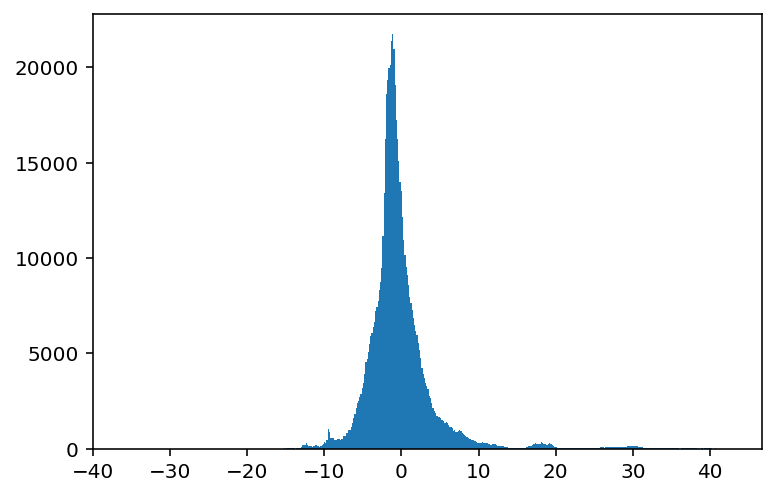

In [50]:
plt.hist(tt,bins=500)
plt.show()

In [51]:
tt = np.array(tt)

In [52]:
for d in trainlist:
    d.y = (d.y-tmean)/tsd
for d in vallist:
    d.y = (d.y-tmean)/tsd

In [53]:
tt2 = []
for d in trainlist:
    tt2.append(d.y)
for d in vallist:
    tt2.append(d.y)

In [54]:
tt2 = np.array(tt2)

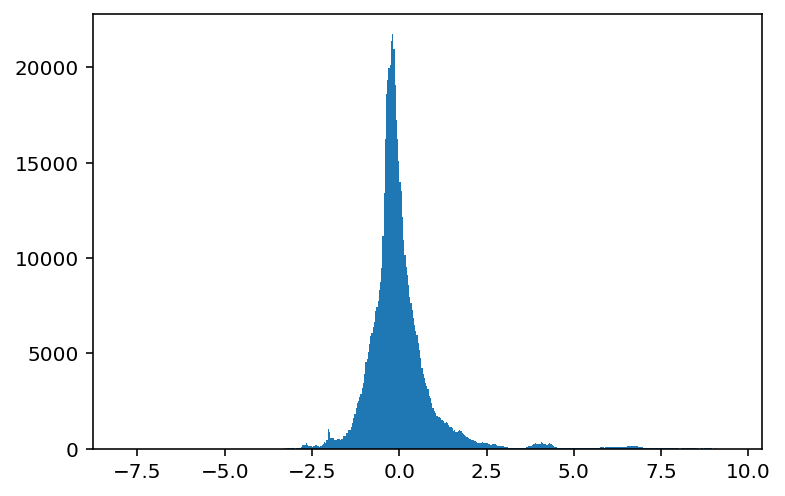

In [55]:
plt.hist(tt2,bins=500)
plt.show()

In [56]:
val_loader = DataLoader(vallist, batch_size=256,shuffle=False)
train_loader = DataLoader(trainlist, batch_size=256,shuffle=True)

In [57]:
#import gc
#del train_loader,val_loader,model
#gc.collect()
#torch.cuda.empty_cache()

In [58]:
ndim =128
edim = 64

In [59]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.lin0 = torch.nn.Linear(189, ndim)
        self.bn0 = BatchNorm1d(ndim)
        self.d0 = Dropout(0.1)
        
        nn = Sequential(Linear(25, edim), ReLU(), Linear(edim,2*edim), ReLU(),Linear(2*edim, ndim * ndim))
        self.conv = NNConv(ndim, ndim, nn, aggr='max', root_weight=True)
        self.gru = GRU(ndim, ndim)
        
        self.set2set = Set2Set(ndim, processing_steps=3)
        self.lin1 = torch.nn.Linear(2*ndim, 192)
        self.lin2 = torch.nn.Linear(192,160)
        self.lin3 = torch.nn.Linear(160, ndim)
        self.lin4 = torch.nn.Linear(ndim, 1)

    def forward(self, data):
        out = F.selu(self.lin0(data.x))
        out = self.bn0(out)
        out = self.d0(out)
        h = out.unsqueeze(0)
        
        for i in range(3):
            m = F.selu(self.conv(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)
        
        out = self.set2set(out, data.batch)
        out = F.selu(self.lin1(out))
        out = F.selu(self.lin2(out))
        out = F.selu(self.lin3(out))
        out = self.lin4(out)
        
        return out.view(-1)

In [60]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
# #model = torch.load('MPNN_64DIM_MODEL.pth')
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.00001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

In [61]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [62]:
#B2 SAVED AS T2
xd = torch.load('Temp/t1.pth')
model = xd['bestmodel']
lrr = xd['lr']
ep = 300-xd['epoch']
ep = 150
print('error: {}, epoch: {}'.format(xd['val_error'],ep))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = RAdam(model.parameters(), lr=lrr,weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

error: 0.08325632284232966, epoch: 150


In [63]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
# #model = torch.load('MPNN_64DIM_MODEL.pth')
# optimizer = RAdam(model.parameters(), lr=0.001,weight_decay=0.00001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

In [64]:
torch.cuda.empty_cache()

In [65]:
def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        #loss = torch.log(F.l1_loss(model(data),data.y)+ 4e-9)
        loss = F.l1_loss(model(data),data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(loader):
    model.eval()
    error = 0
    for data in loader:
        data = data.to(device)
        error += (model(data) * tsd - data.y * tsd).abs().sum().item()  # MAE
    return error / len(loader.dataset)

In [66]:
#optimizer = RAdam(model.parameters(), lr=0.001,weight_decay=0.00001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

In [67]:
#TRY SET2SET AFTER TOPK POOLING

In [68]:
best_val_error = None
bestmodel = None
for epoch in range(1, ep):
    start = time.time()
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train(epoch)
    val_error = test(val_loader)
    scheduler.step(val_error)
    if best_val_error is None or val_error <= best_val_error:
        best_val_error = val_error
        bestmodel = deepcopy(model)
    if epoch%5 == 0:
        torch.save({'bestmodel':bestmodel,
                    'lr':lr,
                   'epoch':epoch,
                   'val_error':val_error},'Temp/t2.pth')
    end = time.time()
    print('Epoch: {:04d}, LR: {:9f},T Loss: {:.7f}, V MAE: {:.7f}, Time: {:.7f}'.format(epoch, lr, loss, val_error,end-start))

Epoch: 0001, LR:  0.000167,T Loss: 0.0185618, V MAE: 0.0820877, Time: 406.0763233
Epoch: 0002, LR:  0.000167,T Loss: 0.0178091, V MAE: 0.0815808, Time: 404.9941483
Epoch: 0003, LR:  0.000167,T Loss: 0.0170280, V MAE: 0.0805365, Time: 403.9799826
Epoch: 0004, LR:  0.000167,T Loss: 0.0163375, V MAE: 0.0798608, Time: 402.9465082


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 0005, LR:  0.000167,T Loss: 0.0157885, V MAE: 0.0795888, Time: 402.7026446
Epoch: 0006, LR:  0.000167,T Loss: 0.0153398, V MAE: 0.0792009, Time: 402.9321980
Epoch: 0007, LR:  0.000167,T Loss: 0.0148911, V MAE: 0.0792436, Time: 403.3659613
Epoch: 0008, LR:  0.000167,T Loss: 0.0145333, V MAE: 0.0782590, Time: 415.3318439
Epoch: 0009, LR:  0.000167,T Loss: 0.0142488, V MAE: 0.0785259, Time: 415.1693978
Epoch: 0010, LR:  0.000167,T Loss: 0.0139459, V MAE: 0.0785336, Time: 415.2947795
Epoch: 0011, LR:  0.000167,T Loss: 0.0136632, V MAE: 0.0785636, Time: 415.0437028
Epoch: 0012, LR:  0.000167,T Loss: 0.0134043, V MAE: 0.0774100, Time: 414.8319552
Epoch: 0013, LR:  0.000167,T Loss: 0.0131805, V MAE: 0.0782541, Time: 414.0787771
Epoch: 0014, LR:  0.000167,T Loss: 0.0129766, V MAE: 0.0780190, Time: 414.3313618
Epoch: 0015, LR:  0.000167,T Loss: 0.0127523, V MAE: 0.0775710, Time: 414.4709773
Epoch: 0016, LR:  0.000167,T Loss: 0.0125622, V MAE: 0.0771157, Time: 413.3898902
Epoch: 0017, LR:

KeyboardInterrupt: 

In [ ]:
#del train_loader,val_loader,model
#gc.collect()
#torch.cuda.empty_cache()

In [70]:
torch.save(bestmodel,'MPNN_2JHC_2FE.pth')#OG SELU AND CONNECTED TO TARGETS

In [69]:
print('Best Validation MAE: {}'.format(best_val_error))
print('Best Log Validation MAE: {}'.format(np.log(best_val_error)))

Best Validation MAE: 0.07421922094460437
Best Log Validation MAE: -2.600732119974374


In [ ]:
print(tmean,tsd)